## Scenario 3: building a model trained on both stream gauges and HWMs with considering uncertainties

### Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.layers import Flatten
from sklearn.model_selection import train_test_split
import h5py
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error, mean_squared_error
import random as rn
from scikeras.wrappers import KerasRegressor
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import shap
import warnings



# Set random seeds for reproducibility
np.random.seed(1)
rn.seed(1)
tf.random.set_seed(1)

### Reading the stream gauges and HWM data for hurricane Ida

In [3]:
# Read the CSV file into a pandas DataFrame
df = pd.read_csv('Ida.csv', header=0)

# Set 'Distance to river' and 'HAND' to 0 where 'Type' is 'Stream'
df.loc[df['Type'] == 'Stream', 'Distance to river'] = 0
df.loc[df['Type'] == 'Stream', 'HAND'] = 0

df

,FID,Shape,site_no,latitude,longitude,Uncertainty,Type,Flood,Altitude,Rain,...,Soil moisture,Slope,Curvature,Flow accumulation,TWI,Distance to river,Distance to storm track,Distance to sea,Tide,Mean gauge height
0,0,Point,NJHUN31738,40.503925,-74.865608,0.2,HWMs,1.000000,54.3457,249.6,...,0.428718,0.918132,6191200000,0,-17.601400,0.002459,0.471748,0.594653,1.376270,0.000000
1,1,Point,NJHUN31738,40.503248,-74.865348,0.1,HWMs,2.600000,53.9004,249.6,...,0.428718,0.720335,-83546900,0,-26.235500,0.002509,0.471026,0.594372,1.376520,0.000000
2,2,Point,NJHUN31738,40.503140,-74.864977,0.4,HWMs,2.800000,53.5673,249.6,...,0.428718,1.039240,-655878000,2,0.407577,0.002828,0.470819,0.593998,1.376840,0.000000
3,3,Point,NJHUN31738,40.503246,-74.864752,0.2,HWMs,1.600000,54.3039,249.6,...,0.428718,0.729352,-3452240000,3,1.229210,0.003076,0.470858,0.593776,1.377030,0.000000
4,4,Point,NJSOM31515,40.404814,-74.681513,0.2,HWMs,7.300000,21.0319,226.2,...,0.428718,0.670430,1213090000,0,-29.038100,0.000941,0.325321,0.417992,1.313770,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,352,Point,1374505,41.394583,-73.607472,0.0,Stream,2.502708,101.3900,142.8,...,0.279366,12.305600,-1685520000,4,-5.195090,0.000000,0.979721,0.370593,0.935456,3.757292
353,353,Point,1374531,41.373389,-73.639583,0.0,Stream,5.177292,84.5413,142.9,...,0.352202,1.420260,-1222070000,61,0.623553,0.000000,0.967796,0.360568,0.953227,2.472708
354,354,Point,1374781,41.327361,-73.591472,0.0,Stream,2.503854,104.1990,155.6,...,0.258539,5.531940,203999000,20,-3.207680,0.000000,0.910662,0.303099,0.978951,2.266146
355,355,Point,1374559,41.470472,-73.759583,0.0,Stream,2.766563,183.4710,129.8,...,0.381326,14.157900,3799270000,69,-0.087799,0.000000,1.093210,0.481995,0.902405,1.503437


In [4]:
# List of feature pairs for interaction terms
feature_pairs = [
    ("Uncertainty", "Altitude"),
    ("Uncertainty", "Soil moisture"),
    ("Rain", "Curvature"),
    ("Rain", "Distance to river"),
    ("Rain", "Distance to storm track"),
    ("Rain", "Mean gauge height"),
    ("HAND", "Distance to sea"),
    ("HAND", "Mean gauge height"),
    ("Wind speed", "Soil moisture"),
    ("Wind speed", "Distance to river"),
    ("Wind speed", "Tide"),
    ("Soil moisture", "Tide"),
    ("Soil moisture", "Distance to sea"),
    ("Soil moisture", "Mean gauge height"),
    ("Slope", "Tide"),
    ("Slope", "Mean gauge height"),
    ("Curvature", "Tide"),
    ("Flow accumulation", "Tide"),
    ("Flow accumulation", "Mean gauge height"),
    ("Distance to river", "Tide"),
    ("Distance to river", "Mean gauge height"),
    ("Tide", "Mean gauge height"),
    ("Distance to storm track", "Distance to sea"),
    ("Distance to storm track", "Mean gauge height")
]

# Create the interaction features
for pair in feature_pairs:
    feature1, feature2 = pair
    interaction_term_name = f"{feature1}:{feature2}"
    df[interaction_term_name] = df[feature1] * df[feature2]


### Defining features and the target variable

In [5]:
features= [
    "Uncertainty",
    "Wind speed",
    "Soil moisture",
    "Slope",
    "Curvature",
    "Flow accumulation",
    "Distance to river",
    "Distance to storm track",
    "Distance to sea",
    "Uncertainty:Altitude",
    "Uncertainty:Soil moisture",
    "Rain:Curvature",
    "Rain:Distance to river",
    "Rain:Distance to storm track",
    "Rain:Mean gauge height",
    "HAND:Distance to sea",
    "HAND:Mean gauge height",
    "Wind speed:Soil moisture",
    "Wind speed:Distance to river",
    "Wind speed:Tide",
    "Soil moisture:Tide",
    "Soil moisture:Distance to sea",
    "Soil moisture:Mean gauge height",
    "Slope:Tide",
    "Slope:Mean gauge height",
    "Curvature:Tide",
    "Flow accumulation:Tide",
    "Flow accumulation:Mean gauge height",
    "Distance to river:Tide",
    "Distance to river:Mean gauge height",
    "Tide:Mean gauge height",
    "Distance to storm track:Distance to sea",
    "Distance to storm track:Mean gauge height"
]

x = df[features].copy()


y = df['Flood']* 0.3048  #ft to m
x.shape

(357, 33)

### Splitting and scaling data

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x = scaler.fit_transform(x)


# Split data into training and testing sets
Xtrain, Xtest, Ytrain, Ytest , X_train_indices, X_test_indices= train_test_split(x, y, df.index, test_size=0.2, random_state=64)

### Defining a custom loss function instead of standard one considering uncertainties

In [7]:
# Custom loss function
def custom_loss(y_true, y_pred, uncertainty):
    lower_bound = y_true - uncertainty
    upper_bound = y_true + uncertainty

    # Check if prediction falls within the uncertainty range
    within_range = tf.logical_and(tf.less_equal(y_pred, upper_bound), tf.greater_equal(y_pred, lower_bound))
    
    # Calculate the distance to the nearest edge of the range
    distance_to_range = tf.where(
        within_range,
        tf.zeros_like(y_pred),  # If within range, no penalty
        tf.minimum(tf.abs(y_pred - lower_bound), tf.abs(y_pred - upper_bound))  # Distance to nearest edge
    )
    
    # Define a penalty factor 
    penalty_factor = 1.6
    
    # Calculate the loss as a combination of within range and distance to range
    loss = tf.where(
        within_range,
        tf.zeros_like(y_pred),  # If within range, no penalty
        penalty_factor * distance_to_range
    )
    
    # Return the mean loss
    return tf.reduce_mean(loss)

# Wrapper to handle the uncertainty dynamically, this function should match how you intend to use the model
def loss_wrapper(uncertainty):
    def loss(y_true, y_pred):
        return custom_loss(y_true, y_pred, uncertainty)
    return loss

### Creating a model with custom loss function

In [69]:
# Define the input layer
inputs = tf.keras.Input(shape=(Xtrain.shape[1]))

# Define the hidden layers
hidden = tf.keras.layers.Dense(
    16, 
    activation='relu', 
    kernel_initializer=tf.keras.initializers.he_normal(seed=1),
    bias_initializer='zeros', 
    kernel_regularizer=tf.keras.regularizers.L2(0.01))(inputs)
hidden = tf.keras.layers.BatchNormalization()(hidden)
hidden = tf.keras.layers.Dense(
    32, activation='relu', 
    kernel_initializer=tf.keras.initializers.he_normal(seed=1),
    bias_initializer='zeros', 
    kernel_regularizer=tf.keras.regularizers.L2(0.1))(hidden)
hidden = tf.keras.layers.BatchNormalization()(hidden)
hidden = tf.keras.layers.Dense(
    16, 
    activation='relu', 
    kernel_initializer=tf.keras.initializers.he_normal(seed=1),
    bias_initializer='zeros', 
    kernel_regularizer=tf.keras.regularizers.L2(0.01))(hidden)
hidden = tf.keras.layers.BatchNormalization()(hidden)

# Define the output layer. Make sure the output dimension is correct.
outputs = tf.keras.layers.Dense(1, activation='relu')(hidden) # Ensures output is non-negative

# Create the model
model = tf.keras.models.Model(inputs=inputs, outputs=outputs)


model.summary()


#Define the learning rate schedule
lr = tf.keras.optimizers.schedules.ExponentialDecay(
    0.01,
    decay_steps=50,
    decay_rate=0.92,
    staircase=True
)

opt = tf.keras.optimizers.Adam(learning_rate=lr)


# Define a custom callback function
class CustomEarlyStopping(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['val_loss'] <0.4 and logs['loss']<0.4:
            self.model.stop_training = True

# Create an instance of the custom callback
custom_early_stopping = CustomEarlyStopping()


# Compile the model
model.compile(
    optimizer= opt, 
    loss=loss_wrapper(df['Uncertainty']),
#    metrics=['accuracy']
)
model_checkpoint = ModelCheckpoint('model.h5', 
                                   monitor='val_loss', 
                                   save_best_only=True)
# Train your model
history = model.fit(
    Xtrain,
    Ytrain,
    batch_size=64,
    epochs=2000,
    validation_data=(Xtest, Ytest),
    callbacks=[custom_early_stopping, model_checkpoint]
)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 33)]              0         
                                                                 
 dense_32 (Dense)            (None, 16)                544       
                                                                 
 batch_normalization_24 (Bat  (None, 16)               64        
 chNormalization)                                                
                                                                 
 dense_33 (Dense)            (None, 32)                544       
                                                                 
 batch_normalization_25 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 dense_34 (Dense)            (None, 16)                528 

5/5 [==============================] - 0s 11ms/step - loss: 0.4280 - val_loss: 0.6476
Epoch 148/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.4691 - val_loss: 0.6433
Epoch 149/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.4098 - val_loss: 0.6119
Epoch 150/2000
5/5 [==============================] - 0s 29ms/step - loss: 0.4107 - val_loss: 0.5960
Epoch 151/2000
5/5 [==============================] - 0s 14ms/step - loss: 0.4303 - val_loss: 0.6388
Epoch 152/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.4193 - val_loss: 0.6435
Epoch 153/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.4018 - val_loss: 0.6556
Epoch 154/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.4170 - val_loss: 0.6672
Epoch 155/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.4262 - val_loss: 0.6532
Epoch 156/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.3800 - val_loss: 0.6591
Epoch 1

5/5 [==============================] - 0s 13ms/step - loss: 0.2925 - val_loss: 0.5445
Epoch 310/2000
5/5 [==============================] - 0s 13ms/step - loss: 0.2916 - val_loss: 0.5143
Epoch 311/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.2552 - val_loss: 0.4935
Epoch 312/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.2544 - val_loss: 0.4803
Epoch 313/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.2708 - val_loss: 0.5304
Epoch 314/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.2849 - val_loss: 0.5177
Epoch 315/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.2944 - val_loss: 0.5681
Epoch 316/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.2509 - val_loss: 0.5565
Epoch 317/2000
5/5 [==============================] - 0s 13ms/step - loss: 0.3100 - val_loss: 0.5314
Epoch 318/2000
5/5 [==============================] - 0s 13ms/step - loss: 0.2656 - val_loss: 0.4977
Epoch

5/5 [==============================] - 0s 11ms/step - loss: 0.2669 - val_loss: 0.5174
Epoch 472/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.2489 - val_loss: 0.5110
Epoch 473/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.2358 - val_loss: 0.5037
Epoch 474/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.2338 - val_loss: 0.4952
Epoch 475/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.2790 - val_loss: 0.5004
Epoch 476/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.2228 - val_loss: 0.5178
Epoch 477/2000
5/5 [==============================] - 0s 15ms/step - loss: 0.2671 - val_loss: 0.5184
Epoch 478/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.2429 - val_loss: 0.5178
Epoch 479/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.2530 - val_loss: 0.5228
Epoch 480/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.2021 - val_loss: 0.5206
Epoch 

5/5 [==============================] - 0s 14ms/step - loss: 0.1931 - val_loss: 0.4972
Epoch 634/2000
5/5 [==============================] - 0s 14ms/step - loss: 0.1967 - val_loss: 0.4964
Epoch 635/2000
5/5 [==============================] - 0s 14ms/step - loss: 0.1957 - val_loss: 0.4958
Epoch 636/2000
5/5 [==============================] - 0s 14ms/step - loss: 0.2330 - val_loss: 0.4961
Epoch 637/2000
5/5 [==============================] - 0s 13ms/step - loss: 0.1761 - val_loss: 0.4976
Epoch 638/2000
5/5 [==============================] - 0s 13ms/step - loss: 0.2096 - val_loss: 0.4983
Epoch 639/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.1933 - val_loss: 0.4975
Epoch 640/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.2665 - val_loss: 0.4991
Epoch 641/2000
5/5 [==============================] - 0s 14ms/step - loss: 0.2490 - val_loss: 0.4994
Epoch 642/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.2639 - val_loss: 0.5007
Epoch 

5/5 [==============================] - 0s 11ms/step - loss: 0.2105 - val_loss: 0.4988
Epoch 796/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.2572 - val_loss: 0.4997
Epoch 797/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1939 - val_loss: 0.5013
Epoch 798/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.2300 - val_loss: 0.5024
Epoch 799/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1867 - val_loss: 0.5019
Epoch 800/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1871 - val_loss: 0.5019
Epoch 801/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.2034 - val_loss: 0.5014
Epoch 802/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.2357 - val_loss: 0.5013
Epoch 803/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.2011 - val_loss: 0.5008
Epoch 804/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1993 - val_loss: 0.4998
Epoch 

5/5 [==============================] - 0s 11ms/step - loss: 0.2586 - val_loss: 0.5020
Epoch 958/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1933 - val_loss: 0.5016
Epoch 959/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1979 - val_loss: 0.5012
Epoch 960/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1835 - val_loss: 0.5013
Epoch 961/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.2217 - val_loss: 0.5013
Epoch 962/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.1816 - val_loss: 0.5007
Epoch 963/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.2834 - val_loss: 0.5007
Epoch 964/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.2056 - val_loss: 0.5013
Epoch 965/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.2222 - val_loss: 0.5010
Epoch 966/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1920 - val_loss: 0.5015
Epoch 967

5/5 [==============================] - 0s 10ms/step - loss: 0.2000 - val_loss: 0.5016
Epoch 1039/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.2120 - val_loss: 0.5016
Epoch 1040/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.2790 - val_loss: 0.5018
Epoch 1041/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.2108 - val_loss: 0.5019
Epoch 1042/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1816 - val_loss: 0.5018
Epoch 1043/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.2205 - val_loss: 0.5019
Epoch 1044/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.2634 - val_loss: 0.5022
Epoch 1045/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.2245 - val_loss: 0.5020
Epoch 1046/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.2415 - val_loss: 0.5017
Epoch 1047/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.2315 - val_loss: 0.5015

5/5 [==============================] - 0s 12ms/step - loss: 0.1880 - val_loss: 0.5016
Epoch 1199/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.2388 - val_loss: 0.5009
Epoch 1200/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1875 - val_loss: 0.5011
Epoch 1201/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1812 - val_loss: 0.5011
Epoch 1202/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.2090 - val_loss: 0.5011
Epoch 1203/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.2635 - val_loss: 0.5006
Epoch 1204/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.1701 - val_loss: 0.5004
Epoch 1205/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.2124 - val_loss: 0.5006
Epoch 1206/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.1877 - val_loss: 0.5004
Epoch 1207/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1902 - val_loss: 0.5006

5/5 [==============================] - 0s 9ms/step - loss: 0.2226 - val_loss: 0.5003
Epoch 1359/2000
5/5 [==============================] - 0s 18ms/step - loss: 0.2097 - val_loss: 0.5004
Epoch 1360/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.2071 - val_loss: 0.5007
Epoch 1361/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.2773 - val_loss: 0.5011
Epoch 1362/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.2640 - val_loss: 0.5008
Epoch 1363/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.1759 - val_loss: 0.5008
Epoch 1364/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.2263 - val_loss: 0.5005
Epoch 1365/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.2100 - val_loss: 0.5007
Epoch 1366/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.2022 - val_loss: 0.5007
Epoch 1367/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.1970 - val_loss: 0.5010
Ep

5/5 [==============================] - 0s 12ms/step - loss: 0.1927 - val_loss: 0.5010
Epoch 1519/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.2460 - val_loss: 0.5012
Epoch 1520/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1768 - val_loss: 0.5011
Epoch 1521/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.2037 - val_loss: 0.5012
Epoch 1522/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.2321 - val_loss: 0.5013
Epoch 1523/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.1907 - val_loss: 0.5014
Epoch 1524/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.2123 - val_loss: 0.5011
Epoch 1525/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.2201 - val_loss: 0.5009
Epoch 1526/2000
5/5 [==============================] - 0s 7ms/step - loss: 0.2089 - val_loss: 0.5005
Epoch 1527/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.2467 - val_loss: 0.5004


5/5 [==============================] - 0s 9ms/step - loss: 0.2076 - val_loss: 0.4999
Epoch 1679/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.2279 - val_loss: 0.5000
Epoch 1680/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.2586 - val_loss: 0.5001
Epoch 1681/2000
5/5 [==============================] - 0s 8ms/step - loss: 0.2010 - val_loss: 0.4999
Epoch 1682/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.2302 - val_loss: 0.5001
Epoch 1683/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.2065 - val_loss: 0.4997
Epoch 1684/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.2641 - val_loss: 0.4997
Epoch 1685/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.2059 - val_loss: 0.4998
Epoch 1686/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.2503 - val_loss: 0.4999
Epoch 1687/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.2211 - val_loss: 0.4999

5/5 [==============================] - 0s 12ms/step - loss: 0.3122 - val_loss: 0.5007
Epoch 1839/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.2783 - val_loss: 0.5002
Epoch 1840/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.3134 - val_loss: 0.5002
Epoch 1841/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.1977 - val_loss: 0.5004
Epoch 1842/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.2396 - val_loss: 0.5003
Epoch 1843/2000
5/5 [==============================] - 0s 11ms/step - loss: 0.2036 - val_loss: 0.5006
Epoch 1844/2000
5/5 [==============================] - 0s 13ms/step - loss: 0.2100 - val_loss: 0.5010
Epoch 1845/2000
5/5 [==============================] - 0s 13ms/step - loss: 0.2129 - val_loss: 0.5010
Epoch 1846/2000
5/5 [==============================] - 0s 9ms/step - loss: 0.1635 - val_loss: 0.5007
Epoch 1847/2000
5/5 [==============================] - 0s 12ms/step - loss: 0.1989 - val_loss: 0.50

5/5 [==============================] - 0s 12ms/step - loss: 0.2433 - val_loss: 0.5007
Epoch 1999/2000
5/5 [==============================] - 0s 13ms/step - loss: 0.1954 - val_loss: 0.5006
Epoch 2000/2000
5/5 [==============================] - 0s 10ms/step - loss: 0.2044 - val_loss: 0.5013


### Evaluating model performance on both the training and test data.

In [9]:
train_hwmquality = df.loc[X_train_indices, 'Uncertainty']
test_hwmquality = df.loc[X_test_indices, 'Uncertainty']
Ytrain_pred=model.predict(Xtrain)
Ytest_pred=model.predict(Xtest)

In [10]:
def custom_r2_score(y_true, y_pred, hwmquality):
    lower_bounds = y_true - hwmquality
    upper_bounds = y_true + hwmquality

    # Calculate the squared error
    mean= np.mean(y_true)
    squared_error = np.square(mean - y_true)

    # Mask values within the range
    masked_squared_error = np.minimum(np.square(y_pred - lower_bounds), np.square(y_pred - upper_bounds))

    # Calculate the custom R-squared
    total_error = np.sum(squared_error)
    total_masked_error = np.sum(masked_squared_error)


    if total_error == 0:
        custom_r2 = 1  # Handle potential division by zero
    else:
        custom_r2 = 1 - (total_masked_error / total_error)

    return custom_r2

train_custom_r2 = custom_r2_score(Ytrain, Ytrain_pred.flatten(), train_hwmquality)
test_custom_r2 = custom_r2_score(Ytest, Ytest_pred.flatten(), test_hwmquality)

print("Train Custom R-squared: {:.2f}".format(train_custom_r2))
print("Test Custom R-squared: {:.2f}".format(test_custom_r2))


Train Custom R-squared: 0.97
Test Custom R-squared: 0.77


In [91]:
def custom_mae(y_true, y_pred, hwmquality):
    lower_bounds = y_true - hwmquality
    upper_bounds = y_true + hwmquality
    masked_absolute_error = np.minimum(np.abs(y_pred - lower_bounds), np.abs(y_pred - upper_bounds))
    return np.mean(masked_absolute_error)

train_custom_mae = custom_mae(Ytrain, Ytrain_pred.flatten(), train_hwmquality)
test_custom_mae = custom_mae(Ytest, Ytest_pred.flatten(), test_hwmquality)

print("Train Custom MAE: {:.2f}".format(train_custom_mae))
print("Test Custom MAE: {:.2f}".format(test_custom_mae))

Train Custom MAE: 0.13
Test Custom MAE: 0.34


In [92]:
def custom_median_absolute_error(y_true, y_pred, hwmquality):
    lower_bounds = y_true - hwmquality
    upper_bounds = y_true + hwmquality
    masked_absolute_error = np.minimum(np.abs(y_pred - lower_bounds), np.abs(y_pred - upper_bounds))
    return np.median(masked_absolute_error)

train_custom_median = custom_median_absolute_error(Ytrain, Ytrain_pred.flatten(), train_hwmquality)
test_custom_median = custom_median_absolute_error(Ytest, Ytest_pred.flatten(), test_hwmquality)

print("Train Custom MDAE: {:.2f}".format(train_custom_median))
print("Test Custom MDAE: {:.2f}".format(test_custom_median))

Train Custom MDAE: 0.09
Test Custom MDAE: 0.19


In [93]:
def custom_nrmse(y_true, y_pred, hwmquality):
    lower_bounds = y_true - hwmquality
    upper_bounds = y_true + hwmquality
    masked_squared_error = np.minimum(np.square(y_pred - lower_bounds), np.square(y_pred - upper_bounds))
    mean_squared_error = np.mean(masked_squared_error)
    mean_true = np.mean(y_true)
    return np.sqrt(mean_squared_error) *100 / mean_true

train_custom_nrmse = custom_nrmse(Ytrain, Ytrain_pred.flatten(), train_hwmquality)
test_custom_nrmse = custom_nrmse(Ytest, Ytest_pred.flatten(), test_hwmquality)

print("Train Custom NRMSE: {:.2f}".format(train_custom_nrmse))
print("Test Custom NRMSE: {:.2f}".format(test_custom_nrmse))

Train Custom NRMSE: 22.39
Test Custom NRMSE: 55.10


In [94]:
from sklearn import metrics
from sklearn.metrics import r2_score

print("R-squared for training dataset: {:.2f}".format(r2_score(Ytrain, Ytrain_pred)))
print("R-squared for test dataset: {:.2f}".format(r2_score(Ytest, Ytest_pred)))
print("MAE for train: {:.2f}".format(metrics.mean_absolute_error(Ytrain, Ytrain_pred)))
print("MAE for test: {:.2f}".format(metrics.mean_absolute_error(Ytest, Ytest_pred)))

R-squared for training dataset: 0.97
R-squared for test dataset: 0.74
MAE for train: 0.10
MAE for test: 0.37


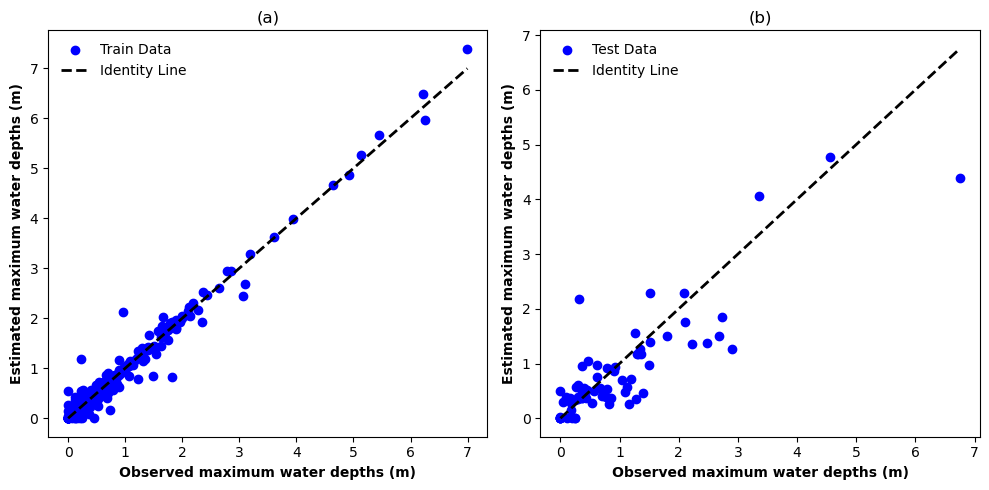

In [95]:
import numpy as np
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Scatter plot for simulated vs observed max flood depths (Train Data)
axes[0].scatter(Ytrain, Ytrain_pred, color='blue', label='Train Data')
axes[0].plot([Ytrain.min(), Ytrain.max()], [Ytrain.min(), Ytrain.max()], 'k--', lw=2, label='Identity Line')
axes[0].set_xlabel('Observed maximum water depths (m)', fontweight='bold')
axes[0].set_ylabel('Estimated maximum water depths (m)', fontweight='bold')
axes[0].set_title('(a)')
axes[0].legend(frameon=False)  # No legend box

# Scatter plot for simulated vs observed max flood depths (Test Data)
axes[1].scatter(Ytest, Ytest_pred, color='blue', label='Test Data')
axes[1].plot([Ytest.min(), Ytest.max()], [Ytest.min(), Ytest.max()], 'k--', lw=2, label='Identity Line')
axes[1].set_xlabel('Observed maximum water depths (m)', fontweight='bold')
axes[1].set_ylabel('Estimated maximum water depths (m)', fontweight='bold')
axes[1].set_title('(b)')
axes[1].legend(frameon=False)  # No legend box

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

### Saving the model

In [11]:
# Specify the path and filename for the model
model_path = 'Scenario3.h5'

# Use the .save() method to save your model
model.save(model_path)

print(f"Model saved to {model_path}")


Model saved to Scenario3.h5


### Evaluating stream gauges, HWMs, and stream gagues + HWMs

In [97]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error, mean_squared_error

def evaluate_model(predictions, actuals, model_name):
    # Flatten predictions if necessary
    predictions = predictions
    
    # Calculate metrics
    r_squared = np.round(r2_score(actuals, predictions), 2)
    mae = mean_absolute_error(actuals, predictions)
    mdae = median_absolute_error(actuals, predictions)
    nrmse = np.sqrt(mean_squared_error(actuals, predictions)) * 100 / np.mean(actuals)
    bias = np.mean(predictions - actuals)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    
    # Prepare DataFrame
    errors_df = pd.DataFrame({
        "Metric": ["R-squared", "MAE", "Median Absolute Error", "NRMSE", "BIAS", "RMSE"],
        "Value": [r_squared, mae, mdae, nrmse, bias, rmse]
    })
    
    # Print the DataFrame to check
    print(f"Errors for {model_name}:")
    print(errors_df)

    # Save to CSV
    errors_df.to_csv(f"errors_{model_name}.csv", index=False)

    return errors_df


In [98]:
# Conversion factor from some unit to meters, assuming 'Flood' is initially in some other units
y_t = df['Flood'] * 0.3048 

# Ensure 'features' contains the correct column names you want to use for the model
x_t = df[features].copy()

# Scale the data
x_t_scaled = scaler.fit_transform(x_t)

# Assuming 'best_model' is already trained and ready to be used for predictions
y_t_pred = model.predict(x_t_scaled).flatten()


errors_df_t = evaluate_model(y_t_pred, y_t, "Overall_S3")


# First, add y_t and y_t_pred to your DataFrame if they aren't already included
df['y_t'] = y_t
df['y_t_pred'] = y_t_pred



# Correct filtering of the DataFrame based on 'Type'
df_strm = df[df['Type'] == 'Stream']

# Conversion factor from some unit to meters, assuming 'Flood' is initially in some other units
y_strm = df_strm['y_t']  
y_strm_pred = df_strm['y_t_pred'] 

errors_df_strm = evaluate_model(y_strm_pred, y_strm, "Stream_S3")


# Correct filtering of the DataFrame based on 'Type'
df_HWM = df[df['Type'] == 'HWMs']

# Conversion factor from some unit to meters, assuming 'Flood' is initially in some other units
y_HWM = df_HWM['y_t']  
y_HWM_pred = df_HWM['y_t_pred'] 

errors_df_HWM = evaluate_model(y_HWM_pred, y_HWM, "HWMs_S3")

12/12 [==============================] - 0s 1ms/step
Errors for Overall_S3:
                  Metric      Value
0              R-squared   0.920000
1                    MAE   0.152319
2  Median Absolute Error   0.065058
3                  NRMSE  34.382251
4                   BIAS  -0.027393
5                   RMSE   0.302592
Errors for Stream_S3:
                  Metric      Value
0              R-squared   0.920000
1                    MAE   0.206715
2  Median Absolute Error   0.066815
3                  NRMSE  22.656530
4                   BIAS  -0.026319
5                   RMSE   0.415629
Errors for HWMs_S3:
                  Metric      Value
0              R-squared   0.740000
1                    MAE   0.131446
2  Median Absolute Error   0.065029
3                  NRMSE  47.830724
4                   BIAS  -0.027805
5                   RMSE   0.245783


In [101]:
# Create a DataFrame
data = {
    'site_no': df_strm['site_no'],
    'Actual': y_strm,  
    'Predicted': y_strm_pred,  # Flatten the Ytrain_pred array
    'Absolute_Error': abs(y_strm_pred- y_strm),
    'Error': y_strm_pred- y_strm,
    'FQ': y_strm_pred*100/y_strm
}


# Create a new DataFrame
output_df = pd.DataFrame(data)


# Save the new DataFrame to a CSV file
output_df.to_csv('Scenario3_strm_Prediction.csv', index=False)

### Transferability

In [99]:
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error, mean_squared_error


# Read the CSV file into a pandas DataFrame
df_Ian = pd.read_csv('Ian.csv', header=0)


# Create the interaction features
for pair in feature_pairs:
    feature1, feature2 = pair
    interaction_term_name = f"{feature1}:{feature2}"
    df_Ian[interaction_term_name] = df_Ian[feature1] * df_Ian[feature2]


x_Ian = df_Ian[features].copy()

y_Ian = df_Ian['Flood']* 0.3048  

# Scale the data
x_Ian_scaled = scaler.fit_transform(x_Ian)


# Evaluate the model on the test set
y_Ian_pred = model.predict(x_Ian_scaled)


print("R-squared for Ian:{}".format(np.round(r2_score(y_Ian, y_Ian_pred), 2)))
print("MAE for Ian: {:.2f}".format(mean_absolute_error(y_Ian, y_Ian_pred)))
print("Median Absolute Error for Ian: {:.2f}".format(median_absolute_error(y_Ian, y_Ian_pred)))
print("Root mean square error for Ian: {}". format(np.round(np.sqrt(mean_squared_error(y_Ian, y_Ian_pred)), 2)))
print("BIAS for Ian: {:.2f}".format(np.mean(y_Ian_pred - y_Ian.values.flatten())))
print("Normalized Root Mean Square Error for Ian: {:.2f}".format(np.sqrt(mean_squared_error( y_Ian, y_Ian_pred))*100 / ( np.mean(y_Ian))))

10/10 [==============================] - 0s 674us/step
R-squared for Ian:-0.33
MAE for Ian: 0.61
Median Absolute Error for Ian: 0.51
Root mean square error for Ian: 0.77
BIAS for Ian: -0.03
Normalized Root Mean Square Error for Ian: 89.10


In [100]:
# Read the CSV file into a pandas DataFrame
df_Michael = pd.read_csv('Micheal.csv', header=0)


# Create the interaction features
for pair in feature_pairs:
    feature1, feature2 = pair
    interaction_term_name = f"{feature1}:{feature2}"
    df_Michael[interaction_term_name] = df_Michael[feature1] * df_Ian[feature2]

x_Michael = df_Michael[features].copy()

y_Michael = df_Michael['Flood']* 0.3048 

# Scale the data
x_Michael_scaled = scaler.fit_transform(x_Michael)


# Evaluate the model on the test set
y_Michael_pred = model.predict(x_Michael_scaled).flatten()

# Calculate R-squared
r_squared = r2_score(y_Michael, y_Michael_pred)


print("R-squared for Michael:{}".format(np.round(r_squared, 2)))
print("MAE for Michael: {:.2f}".format(mean_absolute_error(y_Michael, y_Michael_pred)))
print("MedMichael Absolute Error for Michael: {:.2f}".format(median_absolute_error(y_Michael, y_Michael_pred)))
print("Root mean square error for Michael: {}". format(np.round(np.sqrt(mean_squared_error(y_Michael, y_Michael_pred)), 2)))
print("BIAS for Michael: {:.2f}".format(np.mean(y_Michael_pred - y_Michael.values.flatten())))
print("Normalized Root Mean Square Error for Michael: {:.2f}".format(np.sqrt(mean_squared_error( y_Michael, y_Michael_pred))*100 / ( np.mean(y_Michael))))


3/3 [==============================] - 0s 1ms/step
R-squared for Michael:-0.01
MAE for Michael: 0.53
MedMichael Absolute Error for Michael: 0.34
Root mean square error for Michael: 0.74
BIAS for Michael: -0.14
Normalized Root Mean Square Error for Michael: 86.35
